In [373]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import dash
import dash_core_components as dcc
import dash_html_components as html
from plotly.subplots import make_subplots


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)




# Data set cleaned for Covid-19 modelling

the file COVED_small_flat_table has to be generated via the NOTEBOOK DATA PREPARATION

Goal of the exercise a dynamic dashboard of the last cell in the notebook, where one can select the fit for different countries

Fit of SIR model for Germany cases


In [374]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format


df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df_analyse.sort_values('date',ascending=True)

,Unnamed: 0,date,India,Japan,Hungary,Germany,US
0,0,2020-01-22,0,2,0,0,1
1,1,2020-01-23,0,2,0,0,1
2,2,2020-01-24,0,2,0,0,2
3,3,2020-01-25,0,2,0,0,2
4,4,2020-01-26,0,4,0,0,5
...,...,...,...,...,...,...,...
867,867,2022-06-07,43190282,8960177,1919840,26583016,85003945
868,868,2022-06-08,43197522,8978571,1921486,26660652,85214036
869,869,2022-06-09,43205106,8995359,1921486,26738530,85329656
870,870,2022-06-10,43213435,9010943,1921486,26803867,85468816


In [375]:
## Nice mathematical explanation of the differential SIR 
# https://www.youtube.com/watch?v=NKMHhm2Zbkw

In [376]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
# I0=df_analyse.Germany[35]
I0=df_analyse.India[35]
S0=N0-I0
R0=0

In [377]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [378]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


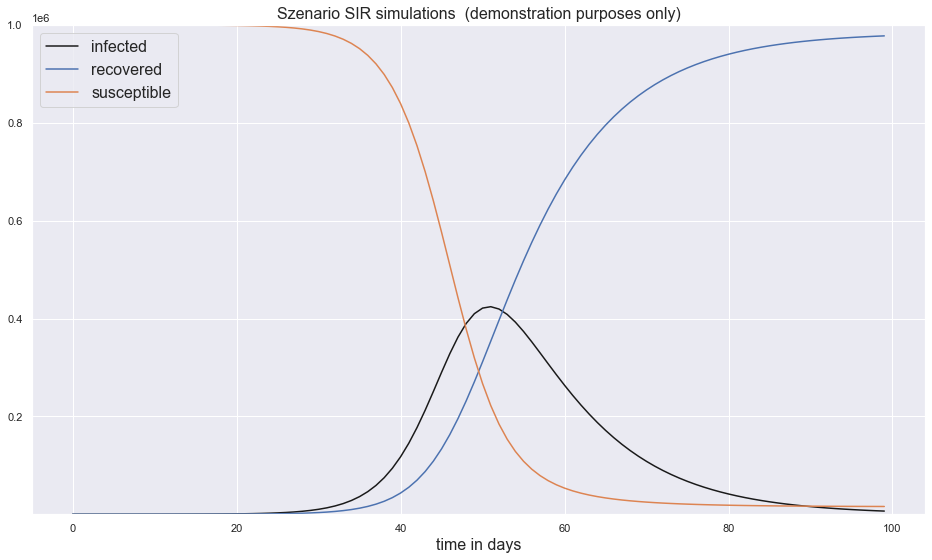

In [379]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting data to a model

## step one: always start on simulative / constructive data

Goal is to fit a data model (SIR) model to obtain the parameters
beta and gamma

step one: always start on simulative / constructive data
step two: cross check if the innerlogic of your parameter fitting is correct

In [380]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [381]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [382]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [383]:
#ydata

In [384]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])



C:\Users\ankur\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-380-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-380-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\ankur\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



standard deviation errors :  [0.00083796 0.00077913]  start infect: 3.8999964
Optimal parameters: beta = 0.37067027489274473  and gamma =  0.09599216307026893


In [385]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

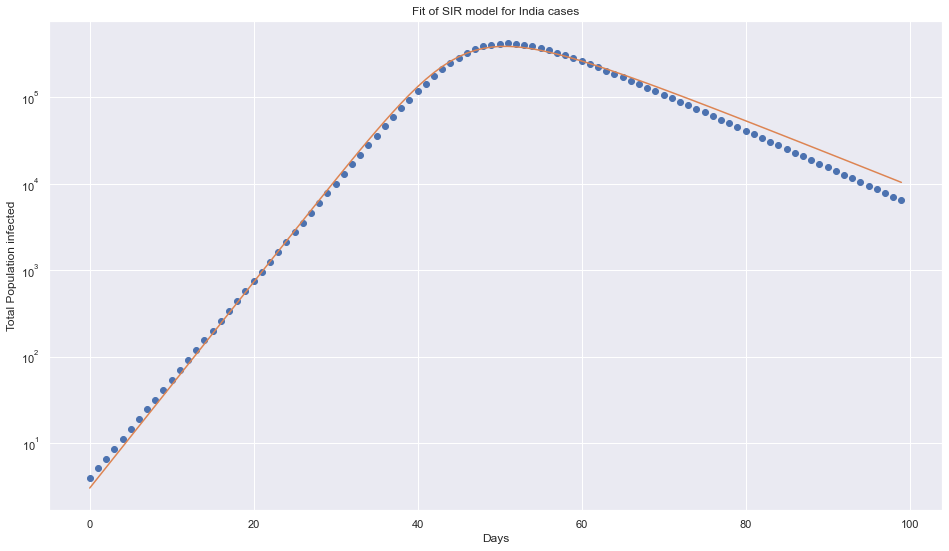

Optimal parameters: beta = 0.37067027489274473  and gamma =  0.09599216307026893
Basic Reproduction Number R0  3.8614639261895136
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [386]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

# plt.title("Fit of SIR model for Germany cases")
plt.title("Fit of SIR model for India cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Fitting the parameters of SIR model
the SIR model is assuming a very simplistic curve
however we can find situations (time windows) where the model might apply

In [412]:
## slice out some true data of a country

ydata = np.array(df_analyse.India[40:200])
t=np.arange(len(ydata))

In [413]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=1300000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 5
cumulative sum of invected after period 2153010
Number of days 160
N0 1300000000


In [414]:

## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

standard deviation errors :  [0.02424527 0.02405177]  start infect: 5
Optimal parameters: beta = 1.7453572418843177  and gamma =  1.6528314470917542


C:\Users\ankur\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-393-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-393-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-393-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\ankur\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



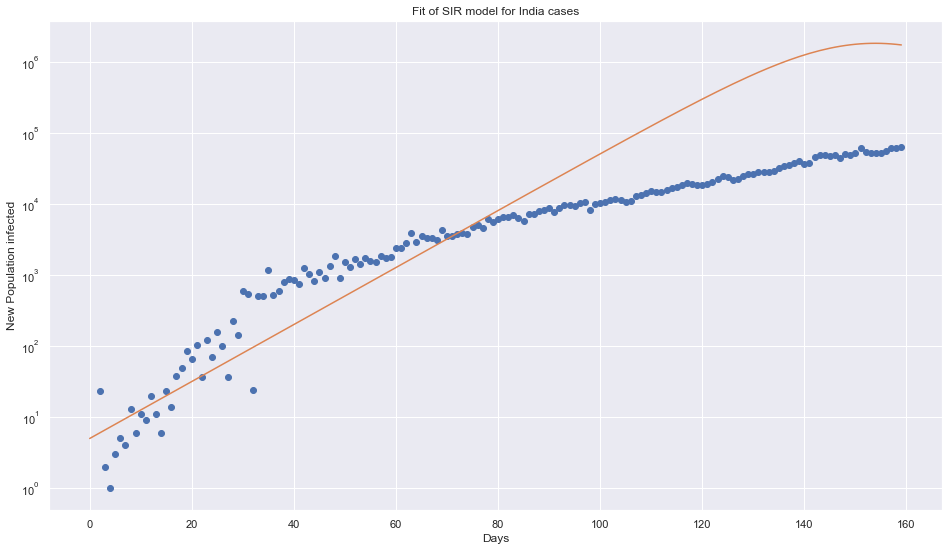

Optimal parameters: beta = 1.7453572418843177  and gamma =  1.6528314470917542
Basic Reproduction Number R0  1.0559801756890381
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [415]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for India cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [416]:
df_india = pd.DataFrame([])
df_india['india_x'] = t
df_india['india_y']= np.ediff1d(ydata, to_begin=ydata[1]-ydata[0])
df_india['india_fit_x'] = t
df_india['india_fit_y'] = fitted


# Japan

In [417]:
N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Japan[35]
S0=N0-I0
R0=0
print(I0)

192


In [418]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


In [419]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


In [420]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [421]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [422]:
ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [423]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])


standard deviation errors :  [0.00093375 0.00067529]  start infect: 249.5852544
Optimal parameters: beta = 0.3780904555636843  and gamma =  0.0965436832711159


<ipython-input-420-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-420-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\ankur\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



In [424]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

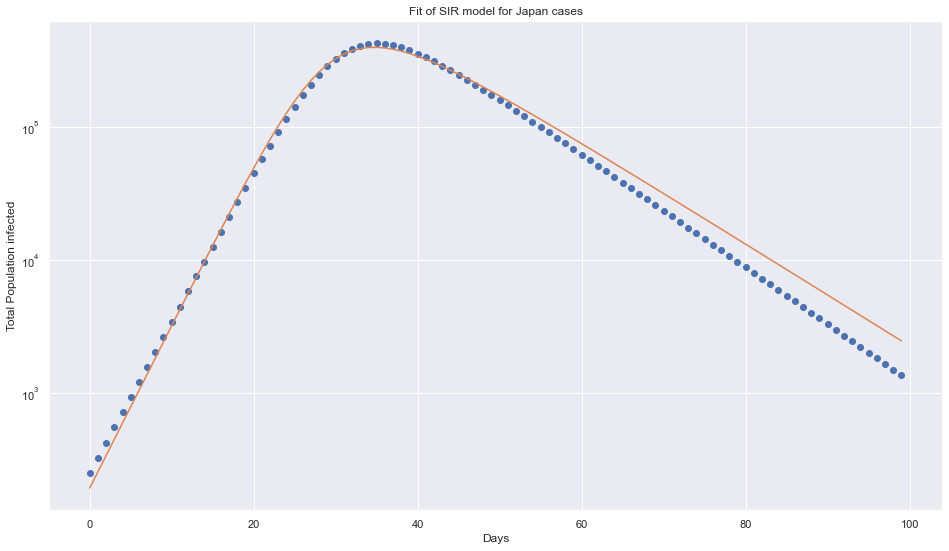

Optimal parameters: beta = 0.3780904555636843  and gamma =  0.0965436832711159
Basic Reproduction Number R0  3.9162630091698816
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [425]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Japan cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [427]:
ydata = np.array(df_analyse.Japan[40:200])
t=np.arange(len(ydata))

In [428]:
N0=120000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 278
cumulative sum of invected after period 47348
Number of days 160
N0 120000000


In [429]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

standard deviation errors :  [0.06997176 0.06931615]  start infect: 278
Optimal parameters: beta = 1.6586507763820921  and gamma =  1.6189813633161467


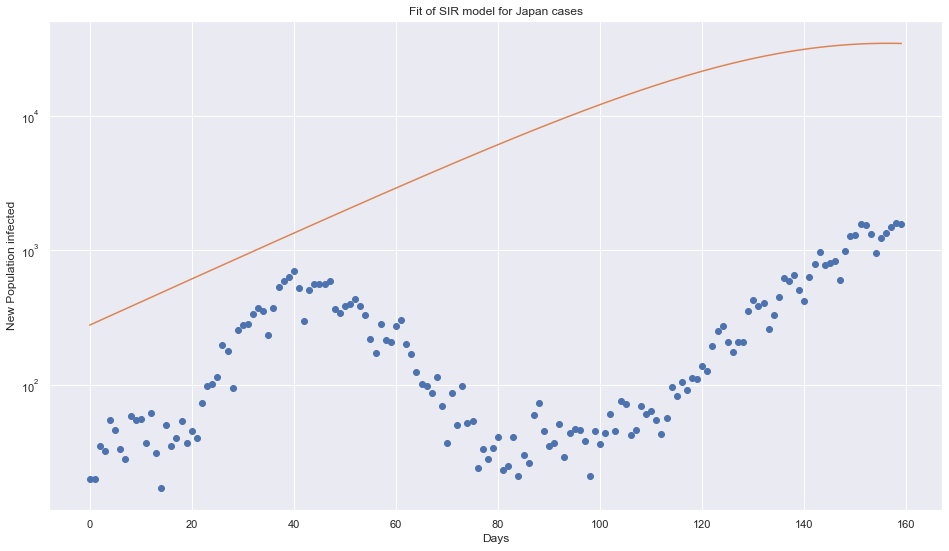

Optimal parameters: beta = 1.6586507763820921  and gamma =  1.6189813633161467
Basic Reproduction Number R0  1.0245026990210009
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [430]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Japan cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [431]:
df_japan = pd.DataFrame([])
df_japan['japan_x'] = t
df_japan['japan_y']= np.ediff1d(ydata, to_begin=ydata[1]-ydata[0])
df_japan['japan_fit_x'] = t
df_japan['japan_fit_y'] = fitted



# germany

In [432]:
N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [433]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


In [434]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


In [435]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [436]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [437]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [438]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])



standard deviation errors :  [0.00087012 0.00074077]  start infect: 27.299823600000003
Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044


<ipython-input-435-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-435-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-435-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\ankur\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



In [439]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

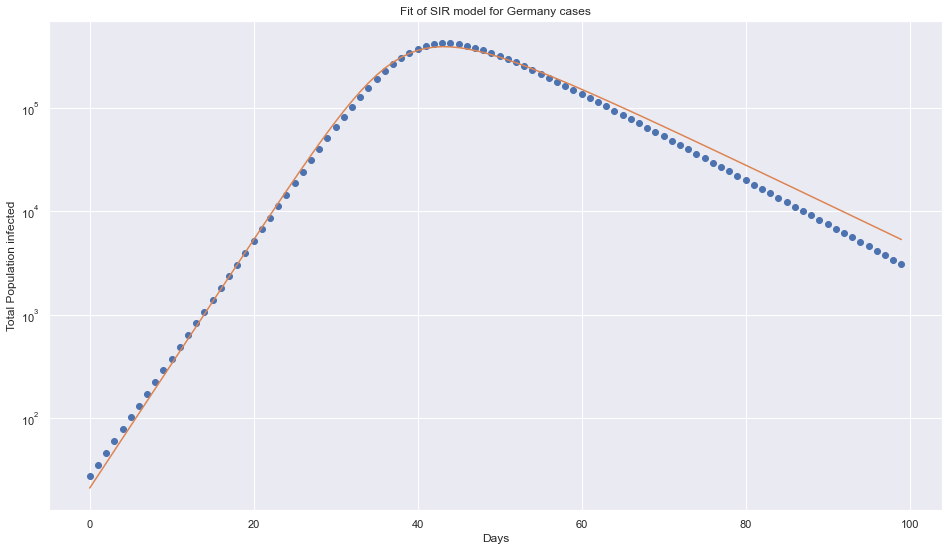

Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044
Basic Reproduction Number R0  3.8812910431198726
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [440]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

# plt.title("Fit of SIR model for Germany cases")
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [444]:
## slice out some true data of a country

ydata = np.array(df_analyse.Germany[40:200])
t=np.arange(len(ydata))

In [445]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=80000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 150
cumulative sum of invected after period 215336
Number of days 160
N0 80000000


In [446]:

## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

standard deviation errors :  [0.02354297 0.02341414]  start infect: 150
Optimal parameters: beta = 0.8967033052727574  and gamma =  0.8250827467439347


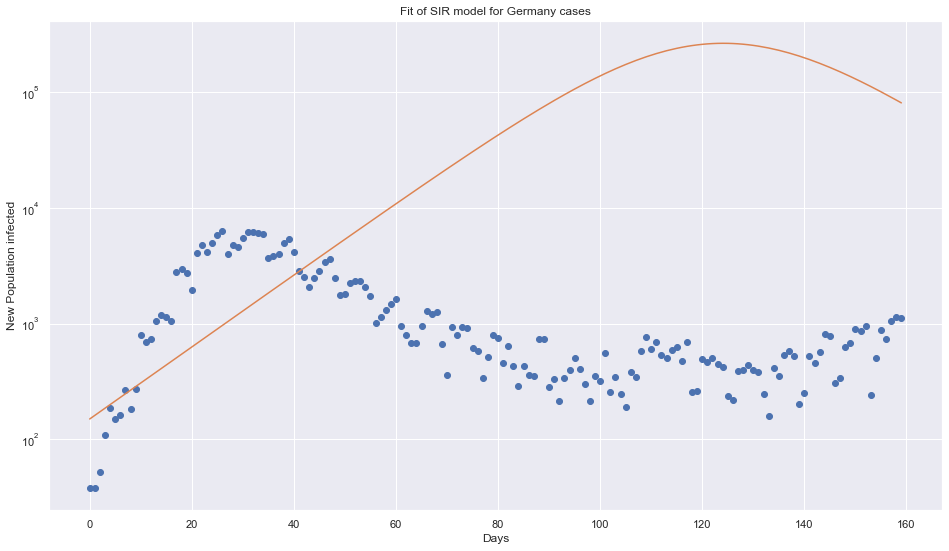

Optimal parameters: beta = 0.8967033052727574  and gamma =  0.8250827467439347
Basic Reproduction Number R0  1.0868040918458937
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [447]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [448]:
df_germany = pd.DataFrame([])
df_germany['germany_x'] = t
df_germany['germany_y']= np.ediff1d(ydata, to_begin=ydata[1]-ydata[0])
df_germany['germany_fit_x'] = t
df_germany['germany_fit_y'] = fitted


In [449]:
import plotly.graph_objects as go
import plotly
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_germany['germany_x'],
                        y=df_germany['germany_y'],
                        mode='markers')
             )
fig.add_trace(go.Scatter(x=df_germany['germany_fit_x'],
                        y=df_germany['germany_fit_y'],
                        mode='lines')
             ) 
fig.update_layout(
title="Fit of SIR model for Germany cases",
width=900,
height=600,
xaxis_title="Days",
yaxis_title="New Population infected",

)
fig.update_yaxes(type="log")

In [369]:
# df_original.to_csv('../data/processed/COVID_original_sir_table.csv',sep=';')

In [450]:
df_original=pd.concat([df_india,df_japan,df_germany],axis=1)

In [457]:
country_list=['india','japan','germany']
app=dash.Dash()
app.layout=html.Div([
    
     dcc.Markdown('''
    #  Applied Data Science on COVID-19 data

    Goal of this task is to use SIR model on COVID-19 data

    '''),
    html.Label('Multi-Select Country'),
    dcc.Dropdown(
    id='country_drop_down',
    options=[
        {'label':'india','value':'india'},
        {'label':'germany','value':'germany'},
        {'label':'japan','value':'japan'}
    ],
    value=['india'],
    multi=True
    ),
    dcc.Markdown('''
        ## SIR model
        '''),
    dcc.Graph(figure=fig,id='main_window_slope')
])

In [458]:
from dash.dependencies import Input,Output
@app.callback(
    Output('main_window_slope','figure'),
    [Input('country_drop_down','value')])
def update_figure(country_list):
    traces=[]
    for each in country_list:
        traces.append(dict(x=df_original[each+'_x'],
                            y=df_original[each+'_y'],
                            mode='markers',
                            opacity=0.8,
                            name=each
                          ))

    for each in country_list:
        traces.append(dict(x=df_original[each+'_fit_x'],
                            y=df_original[each+'_fit_y'],
                            mode='lines',
                           name=each
                          ))
        
    return{
        'data':traces,
        'layout':dict(
             width=1280,
             height=720,
#             xaxis_title="Days",
#             yaxis_title="New Population infected",
            xaxis={'title':'Days',
                    'tickangle':-45,
                   'nticks':20,
                   'tickfont':dict(size=14,color="#7f7f7f"),
            },
            yaxis={'type':'log',
                   'range':'[1.1,5.5]',
                   'title':'New Population infected',
                   
                
            }
        )
    }
if __name__ == '__main__':
    app.run_server(debug=True,use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
